In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectionSlider

import comet_ml

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

#from stumpy import stump, mstump

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import optuna

from model_lgbm import train_lgbm, train_best_lgbm, lgbm_plot_evals, lgbm_f1, double_soft_f1_loss
from utils import create_tensor, agg_over_months, cv_split, min_max_scaling, study_summary


plt.rcParams["figure.figsize"] = (12, 6)
#np.random.seed(0)

# Setup

In [2]:
train_df = pd.read_csv("./data/train.csv", index_col=0).drop_duplicates()
test_df = pd.read_csv("./data/test_nolabels.csv", index_col=0)

y1_weight = train_df.LABELS.sum() / train_df.shape[0]
# y1_weight = 0.6757894386583703

In [3]:
# Constants to select pandas columns efficiently
# all months abbreviations: jan, feb, mar, etc.
MONTHS = [m.lower() for m in pd.date_range(0, freq="M", periods=12).strftime("%b").to_list()]

# return all columns based on MONTH: train_df[COL_BY_MONTH["jan"]]
COL_BY_MONTH = {}
for month in MONTHS:
    COL_BY_MONTH[month] = [col for col in train_df.columns if month in col]

# all features
FEATURES = [col for col in train_df.columns if col != "LABELS"]
# all features with the month stripped: S2_B2_
COL_BASE = list({col[:-3] for col in FEATURES})
# return all columns based on FEATURE (e.g., across months): train_df[COL_BY_FEATURE["S2_B2_"]]
# alternatively, you can select the same df using: train_df[COL_BY_FEATURE[FEATURES[0]]]
COL_BY_FEATURE = {}
for feature in COL_BASE:
    COL_BY_FEATURE[feature] = [col for col in train_df.columns if feature in col]

In [4]:
train_df[COL_BY_MONTH[MONTHS[0]]].head()

,S2_B2_jan,S2_B3_jan,S2_B4_jan,S2_B5_jan,S2_B6_jan,S2_B7_jan,S2_B8_jan,S2_B8A_jan,S2_B9_jan,S2_B11_jan,S2_B12_jan,S1_VV_jan,S1_VH_jan,ERA5_temperature_2m_jan,ERA5_total_precipitation_jan,topo_elevation_jan,topo_slope_jan,NDVI_jan
0,-14.271277,-21.134172,957.531174,1019.557045,1230.022834,1435.138891,1693.702270,1805.411109,1891.557355,2020.567257,813.448973,2080.473917,1323.079548,281.709319,0.000211,1985.132508,0.889839,0.279574
1,-12.341429,-14.744978,949.227883,895.845779,987.517322,1350.496916,1930.239804,2048.686546,2375.680146,2259.903290,1094.947052,1946.566875,1222.287890,261.859364,0.003898,106.947249,1.556351,0.385015
2,-12.317847,-17.026201,1087.616069,1086.401035,1185.755955,1529.674085,1858.981635,1904.667487,2082.954737,2115.713139,901.358672,2089.401053,1264.965439,268.225405,0.001464,129.077506,2.330955,0.275852
3,-15.332478,-20.978203,2987.224569,3163.553102,3412.572434,3908.443371,4044.232162,4231.353770,3682.709329,4518.882323,2121.807152,3491.953331,2794.092937,270.616801,0.000489,828.586052,8.927409,0.158648
4,-11.739502,-11.374262,691.825857,782.111227,478.448214,976.753128,3189.134129,3813.893119,3861.824527,4174.591554,770.429333,1596.424758,570.320228,288.666184,0.004786,98.287583,1.365836,0.640834


# Preprocessing

In [6]:
agg_df = agg_over_months(train_df, freq=3)
agg_df.head()

,S2_B11_03_mean,S2_B11_36_mean,S2_B11_69_mean,S2_B11_912_mean,S2_B8_03_mean,S2_B8_36_mean,S2_B8_69_mean,S2_B8_912_mean,S2_B3_03_mean,S2_B3_36_mean,...,S1_VH_912_mean,S2_B2_03_mean,S2_B2_36_mean,S2_B2_69_mean,S2_B2_912_mean,S2_B4_03_mean,S2_B4_36_mean,S2_B4_69_mean,S2_B4_912_mean,LABELS
0,2417.803938,2366.037185,2855.235345,2488.196876,1822.371903,1910.943299,2202.926570,1787.262333,-23.005993,-17.542178,...,1621.973074,-14.093836,-9.991954,-10.943987,-12.976085,1217.194623,1088.566764,1023.633468,1004.677530,0.0
1,2592.849992,3198.384797,4148.778791,2974.858992,1960.925590,2518.561182,2910.094462,2268.480095,-16.470674,-15.924802,...,1326.926113,-12.297835,-9.635970,-9.414786,-10.779338,1060.569122,990.004869,891.029794,1758.828447,1.0
2,3182.948728,3448.907086,2667.811418,2324.849553,2335.310297,2268.746363,2246.776219,2053.288444,-18.679340,-19.910010,...,1095.221599,-12.029185,-14.055901,-12.547398,-8.222271,1067.607754,950.594239,1382.164990,1791.800181,1.0
3,4217.652093,3635.699848,3335.017144,2689.928443,3515.909177,3120.856027,2834.822866,2147.374359,-21.724712,-19.044137,...,1518.723401,-15.718212,-14.757593,-13.748250,-14.320380,2141.029931,1389.524034,1504.341862,1388.253979,1.0
4,3975.322629,2021.584636,7133.320675,4262.261776,3005.630715,1559.090814,6431.688924,3144.227681,-12.220319,-11.323321,...,1362.462183,-9.934025,-6.653412,-9.176670,-7.625073,1936.049860,902.307975,5225.134432,1569.851896,1.0


In [7]:
scaled_train, scaled_test = min_max_scaling(train_df, test_df)

# Cross-validation

In [8]:
eval_sets = cv_split(scaled_train, n_splits=3)
# x_train = eval_sets[0]["train"][0]
# y_train = eval_sets[0]["train"][1]

# LGBM

C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


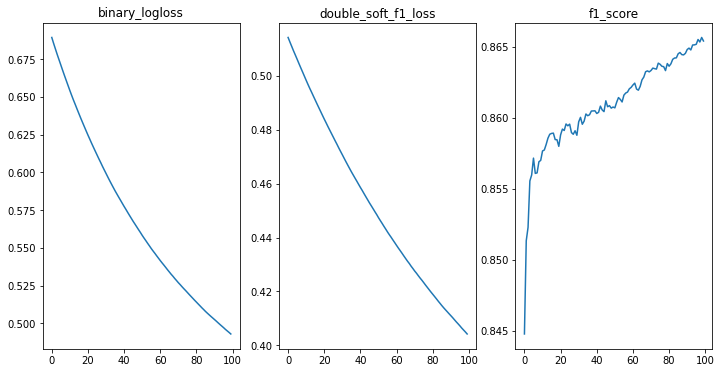

In [14]:
clf = train_lgbm(eval_sets)
lgbm_plot_evals(clf)

## optuna optimization

In [ ]:
def objective(trial, train_df):
    # hyperparameter grid for Optuna to explore
    hyperparams = {
        "device_type": trial.suggest_categorical("device_type", ["gpu"]),
        # structure
        "max_depth": trial.suggest_int("max_depth", 3, 12, step=1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=50),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        # accuracy
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),
        # overfitting
        #"max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }
    
    # split features and labels
    x_df = train_df.loc[:, ~train_df.columns.isin(["LABELS"])]
    y_df = train_df.loc[:, "LABELS"]
    # create cross-validation folds object
    kfold_cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    # hold the best score of each fold
    cv_scores = []
    for idx, (train_idx, test_idx) in enumerate(kfold_cv.split(x_df, y_df)):
        # train-validation split for each fold
        x_train, x_test = x_df.iloc[train_idx], x_df.iloc[test_idx]
        y_train, y_test = y_df.iloc[train_idx], y_df.iloc[test_idx]
        
        # train classifier with optuna hyperparameters
        clf = LGBMClassifier(objective="binary", verbose=-1, **hyperparams)
        clf.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric=["logloss", "double_soft_f1_loss"],
            verbose=False,
        )
        
        # store the best score to the CV score
        best_score = clf.best_score_["valid_0"]["binary_logloss"]#["double_soft_f1_loss"]
        cv_scores.append(best_score)
    
    # return the average best score across CV folds
    return np.mean(cv_scores)

In [ ]:
# create optuna study
study = optuna.create_study(direction="minimize", study_name="lgbm3")
optimize = lambda trial: objective(trial, train_df)

In [ ]:
# launch optuna study
study.optimize(optimize, n_trials=2)

In [ ]:
study_summary(study)

In [ ]:
# pass the optuna best parameters as hyperparameters
best_clf = train_best_lgbm(train_df, study.best_params)

In [ ]:
preds = best_clf.predict(test_df)

# Save prediction

In [7]:
save_pred(test_df, rand_pred, "rand6")